<a href="https://colab.research.google.com/github/daniaprodu/Consultoria-ADC/blob/main/ML_estimative_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trabalho de Conclusão de Curso apresentado para obtenção do título de especialista em Engenharia de Software – 2025

#Modelo Preditivo para Melhorar Estimativas de Tarefas em Desenvolvimento de Software


A presente pesquisa utiliza dados reais coletados entre janeiro e maio de 2025, referentes ao desenvolvimento de software em uma coordenadoria de TI. A base de dados foi extraída de registros de tarefas em um sistema de gestão (formato .csv), contendo colunas como:
status, responsável, senioridade, pontuação_complexidade, pontuação, duração_estimada, duração_impedimento, motivo_impedimento, aberto_em e finalizado_em.

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

url = "https://raw.githubusercontent.com/daniaprodu/task-delay-prediction-ml/main/stories_data.csv"
df = pd.read_csv(
    url,
    sep=';',
    encoding='utf-8-sig',
    on_bad_lines='skip')

df['aberto_em'] = pd.to_datetime(df['aberto_em'], dayfirst=True, errors='coerce')
df['finalizado_em'] = pd.to_datetime(df['finalizado_em'], dayfirst=True, errors='coerce')

# Colunas para string
string_cols = ['status', 'responsavel', 'senioridade', 'motivo_impedimento']
df[string_cols] = df[string_cols].astype('string')

# Colunas para inteiros (substituindo possíveis NaNs com 0)
int_cols = ['pontuacao_complexidade', 'pontuacao']
df[int_cols] = df[int_cols].fillna(0).astype('int64')

# Substituindo NAs por "desconhecido" nas colunas de categorias
df['senioridade'] = df['senioridade'].fillna('desconhecido')
df['motivo_impedimento'] = df['motivo_impedimento'].fillna('nenhum')

# 1. Calcular duração real em dias úteis
df['duracao_real'] = (df['finalizado_em'] - df['aberto_em']).dt.days

# 2. Mapear duracao_estimada para dias
tamanho_para_dias = {'PP': 5, 'P': 10, 'M': 15, 'G': 20, 'GG': 25}
df['duracao_estimada_dias'] = df['duracao_estimada'].map(tamanho_para_dias)

# 3. Converter duracao_impedimento para dias
df['duracao_impedimento_dias'] = df['duracao_impedimento'] / (60 * 60 * 24)

# 4. Criar variável 'teve_impedimento'
df['teve_impedimento'] = df['duracao_impedimento'] > 0

# --- Resultado final ---
print("\nAmostra dos dados processados:")
print(df.head())


Amostra dos dados processados:
    status responsavel senioridade  pontuacao_complexidade  pontuacao  \
0  Ativado       Dev 1       Pleno                      26          3   
1  Ativado       Dev 2       Pleno                      17          0   
2  Ativado       Dev 3       Pleno                      35          1   
3  Ativado       Dev 4       Pleno                      25          3   
4  Ativado      Dev 20      Junior                       4          0   

  duracao_estimada  duracao_impedimento       finalizado_em  \
0                P                    0 2025-01-27 16:32:05   
1               PP                    0 2025-01-17 10:08:59   
2               PP                    0 2025-01-15 16:15:52   
3               PP                    0 2025-02-12 10:07:40   
4               PP                    0 2025-01-22 11:15:56   

  motivo_impedimento           aberto_em  duracao_real  duracao_estimada_dias  \
0             nenhum 2025-01-02 10:01:16            25               

1. Estatísticas Descritivas Básicas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de estilo
sns.set(style="whitegrid")

# Estatísticas das variáveis numéricas
print("\nEstatísticas das variáveis numéricas:")
print(df[['pontuacao_complexidade', 'pontuacao', 'duracao_real', 'duracao_estimada_dias', 'duracao_impedimento_dias']].describe())

# Contagem de valores categóricos
print("\nContagem por senioridade:")
print(df['senioridade'].value_counts())

print("\nContagem de impedimentos:")
print(df['teve_impedimento'].value_counts())


Estatísticas das variáveis numéricas:
       pontuacao_complexidade   pontuacao  duracao_real  \
count              331.000000  331.000000    331.000000   
mean                14.015106    2.788520     17.166163   
std                 15.131036    2.249038     15.685533   
min                  0.000000    0.000000      0.000000   
25%                  0.000000    1.000000      6.000000   
50%                 14.000000    3.000000     13.000000   
75%                 24.000000    5.000000     23.500000   
max                116.000000   13.000000     89.000000   

       duracao_estimada_dias  duracao_impedimento_dias  
count             331.000000                331.000000  
mean                6.873112                  0.976089  
std                 2.958639                  3.700150  
min                 5.000000                  0.000000  
25%                 5.000000                  0.000000  
50%                 5.000000                  0.000000  
75%                10.000000  

2. Visualizações Chave


A. Distribuição da Duração Real

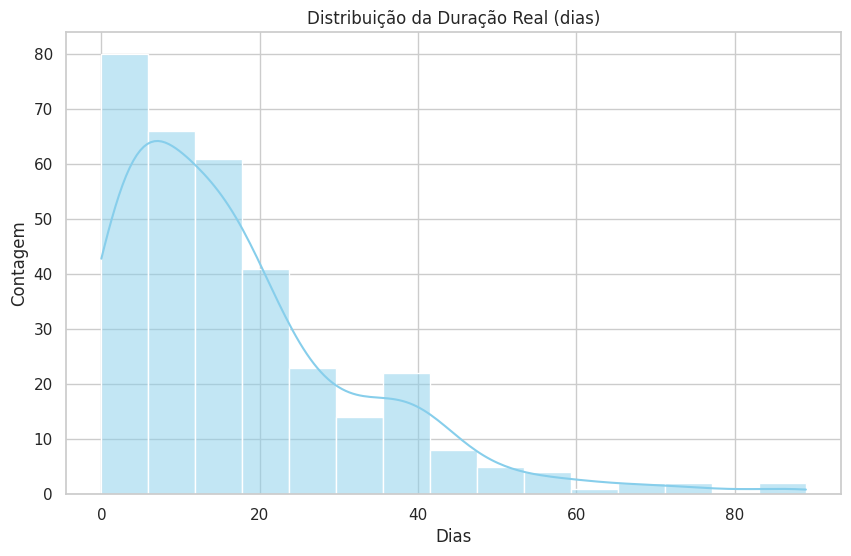

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['duracao_real'].dropna(), bins=15, kde=True, color='skyblue')
plt.title('Distribuição da Duração Real (dias)')
plt.xlabel('Dias')
plt.ylabel('Contagem')
plt.show()

B. Duração Real vs. Estimada

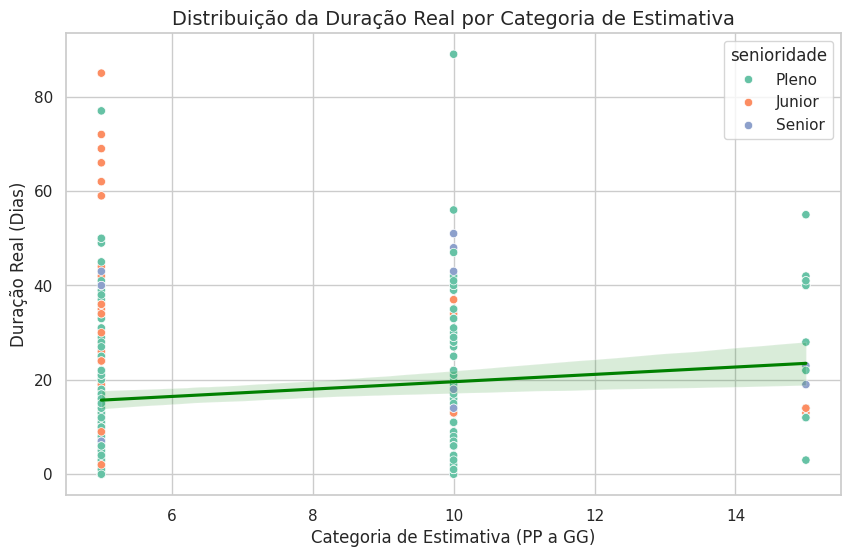

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='duracao_estimada_dias', y='duracao_real', hue='senioridade', data=df, palette='Set2')
sns.regplot(x='duracao_estimada_dias', y='duracao_real', data=df, scatter=False, color='green')
plt.title('Distribuição da Duração Real por Categoria de Estimativa', fontsize=14)
plt.xlabel('Categoria de Estimativa (PP a GG)')
plt.ylabel('Duração Real (Dias)')
plt.show()

* Pontos acima da linha: Estimativas subestimadas (prazo real > estimado).

* Pontos abaixo da linha: Estimativas superestimadas (prazo real < estimado).

C. Correlação entre Complexidade e Duração

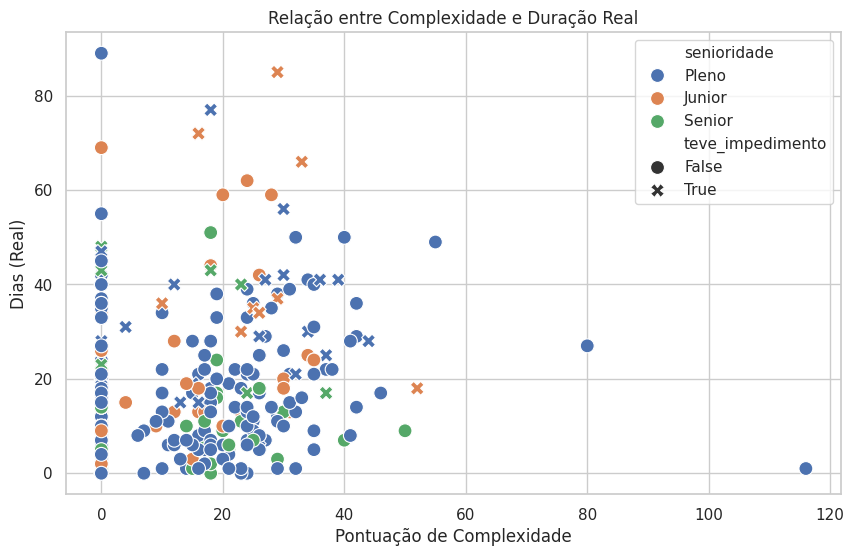

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pontuacao_complexidade', y='duracao_real', data=df, hue='senioridade', style='teve_impedimento', s=100)
plt.title('Relação entre Complexidade e Duração Real')
plt.xlabel('Pontuação de Complexidade')
plt.ylabel('Dias (Real)')
plt.show()

* Pontos vermelhos (impedimentos) devem estar acima da tendência geral.

* Se houver uma linha de tendência clara, complexidade pode ser um bom preditor.

D. Heatmap de Correlações

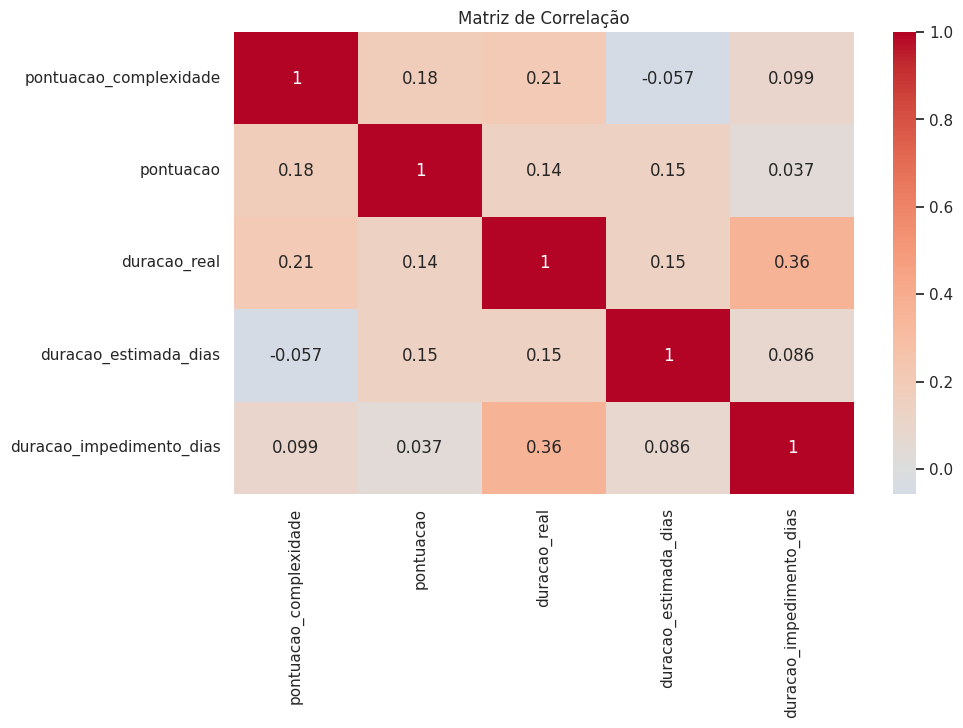

In [ ]:
corr_matrix = df[['pontuacao_complexidade', 'pontuacao', 'duracao_real', 'duracao_estimada_dias', 'duracao_impedimento_dias']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.show()

* Correlação alta entre duracao_real e pontuacao_complexidade sugere que a equipe está estimando com base nesse fator.

* Se duracao_estimada_dias tiver baixa correlação com duracao_real, as estimativas atuais são pouco acuradas.



3. Análise de Impedimentos

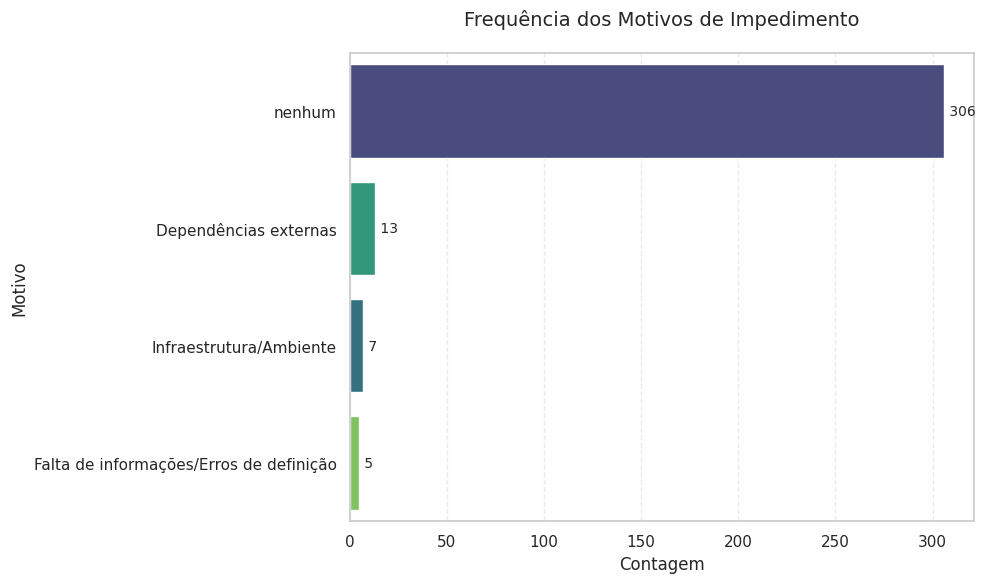


Impacto detalhado por motivo:
                                         Duração Média (dias)  Ocorrências
motivo_impedimento                                                        
Infraestrutura/Ambiente                             36.428571            7
Falta de informações/Erros de definição             32.000000            5
Dependências externas                               25.846154           13
nenhum                                              16.114379          306


In [ ]:
if df['teve_impedimento'].any():
    plt.figure(figsize=(10, 6))

    sns.countplot(
        y='motivo_impedimento',
        data=df,
        order=df['motivo_impedimento'].value_counts().index,
        hue='motivo_impedimento',
        palette='viridis',
        legend=False
    )

    plt.title('Frequência dos Motivos de Impedimento', fontsize=14, pad=20)
    plt.xlabel('Contagem', fontsize=12)
    plt.ylabel('Motivo', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.4)

    for i, count in enumerate(df['motivo_impedimento'].value_counts()):
        plt.text(count + 0.5, i, f' {count}', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Impacto médio dos impedimentos
    impacto = df.groupby('motivo_impedimento')['duracao_real'].agg(['mean', 'count'])
    impacto.columns = ['Duração Média (dias)', 'Ocorrências']
    print("\nImpacto detalhado por motivo:")
    print(impacto.sort_values('Duração Média (dias)', ascending=False))

4. Comparação Entre Duração Real e Estimada focando na estimativa perfeita

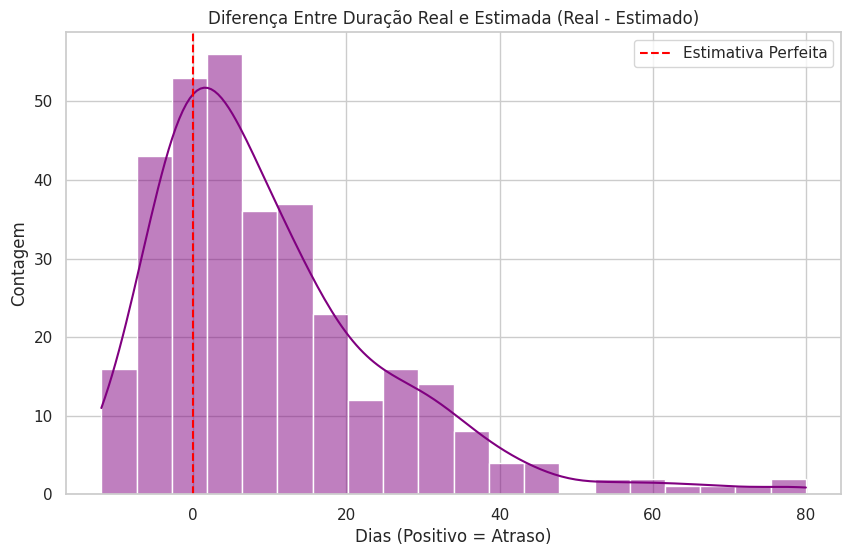

In [ ]:
df['diferenca_estimativa'] = df['duracao_real'] - df['duracao_estimada_dias']

plt.figure(figsize=(10, 6))
sns.histplot(df['diferenca_estimativa'].dropna(), bins=20, kde=True, color='purple')
plt.axvline(0, color='red', linestyle='--', label='Estimativa Perfeita')
plt.title('Diferença Entre Duração Real e Estimada (Real - Estimado)')
plt.xlabel('Dias (Positivo = Atraso)')
plt.ylabel('Contagem')
plt.legend()
plt.show()

* Se a distribuição estiver centrada no 0, as estimativas são acuradas.

* Valores positivos indicam atrasos sistemáticos.

## Modelagem

### Testando modelos

1. Pré-processamento Final

Antes de modelar, garantimos que os dados estão limpos e codificados:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Features e target
X = df[[
    'senioridade',
    'pontuacao_complexidade',
    'pontuacao',
    'duracao_estimada_dias',
    'teve_impedimento',
    'motivo_impedimento'
]]
y = df['duracao_real'].dropna()  # Remove linhas onde y é NaN

# Codificação de variáveis categóricas
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['senioridade', 'motivo_impedimento']),
    ('scaler', StandardScaler(), ['pontuacao_complexidade', 'pontuacao', 'duracao_estimada_dias'])
])

# Dividir dados para treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

2. Modelagem com Random Forest

Random Forest é robusto para dados heterogêneos e captura relações não-lineares.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Treino
model_rf.fit(X_train, y_train)

# Prever e avaliar
y_pred_rf = model_rf.predict(X_test)
print(f"Random Forest - MAE: {mean_absolute_error(y_test, y_pred_rf):.2f} dias")
print(f"Random Forest - R²: {r2_score(y_test, y_pred_rf):.2f}")

Random Forest - MAE: 12.32 dias
Random Forest - R²: -0.08


3. Modelagem com XGBoost

XGBoost geralmente tem melhor performance, mas requer ajuste de hiperparâmetros.

In [ ]:
from xgboost import XGBRegressor

model_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)
print(f"\nXGBoost - MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f} dias")
print(f"XGBoost - R²: {r2_score(y_test, y_pred_xgb):.2f}")


XGBoost - MAE: 12.85 dias
XGBoost - R²: -0.21


4. Análise de Importância das Variáveis

Entendendo quais features mais impactam as previsões:

<ipython-input-13-4881bea536eb>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_rf, y=feature_names, palette='viridis')


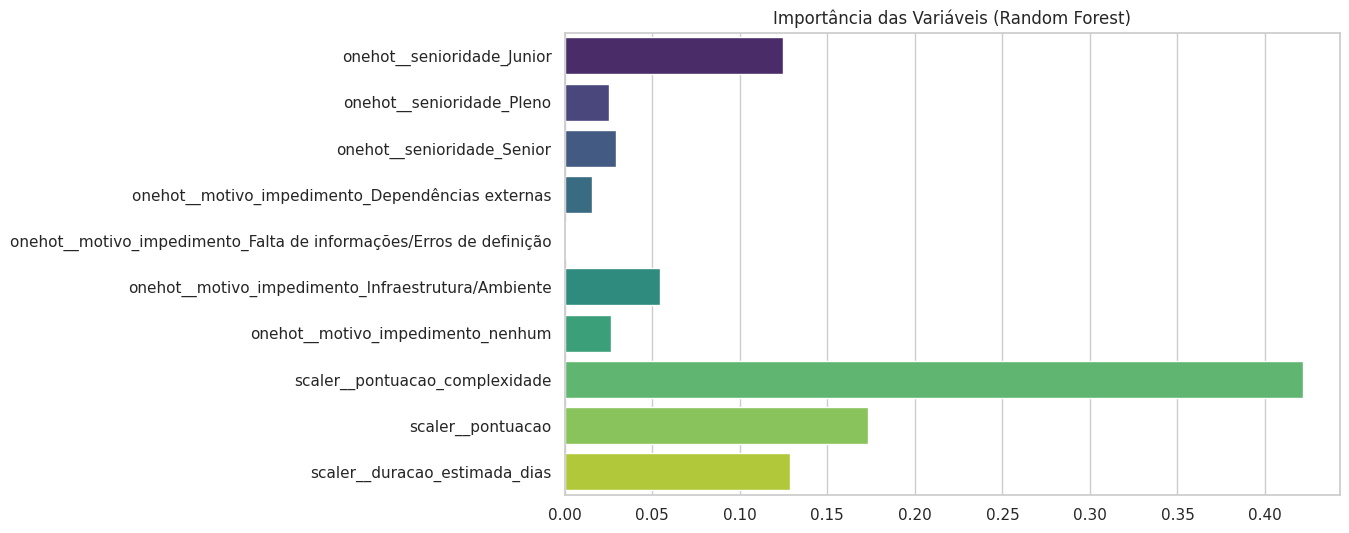

In [ ]:
# Extrair feature names após one-hot encoding
feature_names = model_rf.named_steps['preprocessor'].get_feature_names_out()

# Importância do Random Forest
importances_rf = model_rf.named_steps['regressor'].feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_rf, y=feature_names, palette='viridis')
plt.title('Importância das Variáveis (Random Forest)')
plt.show()

**Que colunas são impressidpiveis para inclusão no modelo?**

* Se pontuacao_complexidade ou duracao_estimada_dias forem as mais importantes, confirma que a equipe já usa esses critérios intuitivamente.

* motivo_impedimento com alta importância justifica incluí-lo no modelo.

5. Validação Cruzada

Para garantir que o modelo não está overfitando:

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_rf, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"\nMAE médio em validação cruzada: {-scores.mean():.2f} dias")


MAE médio em validação cruzada: 12.02 dias


6. Melhorias nos modelos

Melhoria de o XGBoost com GridSearchCV para ajuste de Hiperparâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(model_xgb, param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print(f"Melhores parâmetros: {grid_search.best_params_}")
print(f"Melhor MAE: {-grid_search.best_score_:.2f} dias")

Melhores parâmetros: {'regressor__learning_rate': 0.01, 'regressor__n_estimators': 200}
Melhor MAE: 10.95 dias


7. Salvando modelo

In [ ]:
import joblib
joblib.dump(model_xgb, 'modelo_prazos_xgb.pkl')

['modelo_prazos_xgb.pkl']

## Interpretar o Modelo

Usando SHAP para explicar as previsões:

(SHapley Additive exPlanations), uma das melhores ferramentas para entender como cada variável impacta as previsões. Isso é especialmente útil para justificar prazos estimados para a equipe ou stakeholders.

1. Preparar os Dados Pré-processados
Dados de teste já transformados pelo pipeline (one-hot encoding + scaling):

In [ ]:
import shap

# Aplicar o pré-processador aos dados de teste
X_test_preprocessed = model_rf.named_steps['preprocessor'].transform(X_test)

# Obter os nomes das features após one-hot encoding
feature_names = model_rf.named_steps['preprocessor'].get_feature_names_out()

2. Explicador SHAP para Random Forest

Cada barra mostra o impacto médio absoluto de cada variável nas previsões.

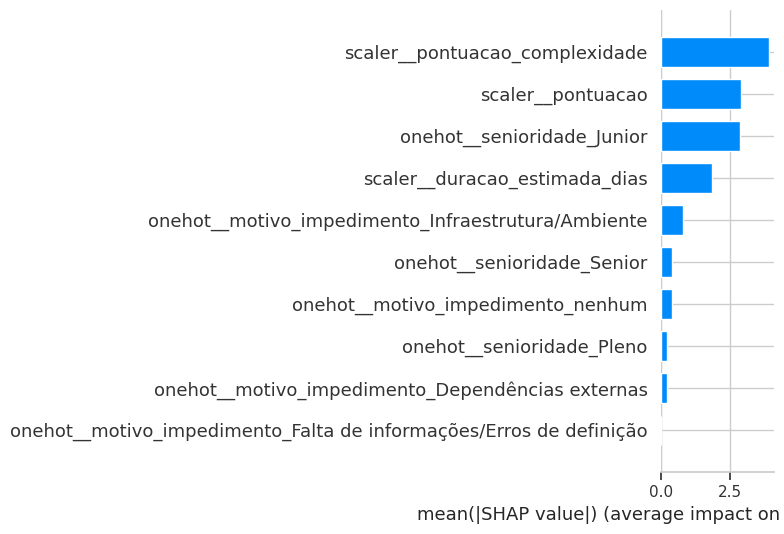

In [ ]:
# 1. Criar o explainer
explainer = shap.TreeExplainer(model_rf.named_steps['regressor'])

# 2. Calcular SHAP values (pode demorar para grandes datasets)
shap_values = explainer.shap_values(X_test_preprocessed)

# 3. Visualizar o impacto médio das variáveis
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, plot_type="bar")

3. Gráfico de Dispersão SHAP

Mostra como o valor de cada feature afeta a previsão:

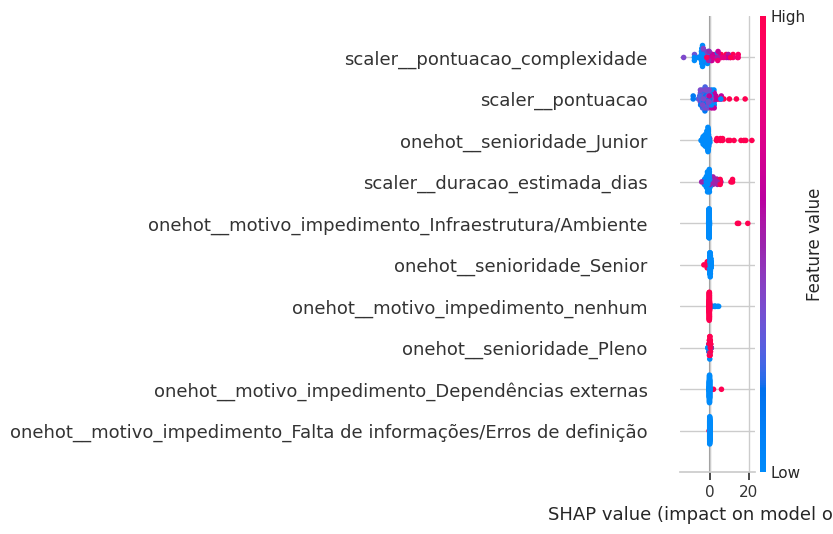

In [ ]:
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names)

* Eixo X: Valor SHAP (impacto na previsão).

* Cor: Valor da feature (vermelho = alto, azul = baixo).

* Pontos vermelhos (alta complexidade) à direita → aumentam a previsão de prazo.

* Seniors (se codificado como senioridade_Senior) tendem a reduzir o prazo.



4. Explicação para uma Previsão Individual

Entendendo por que uma tarefa específica teve certo prazo estimado:

In [1]:
instance_idx = 0
shap.force_plot(
    explainer.expected_value,
    shap_values[instance_idx, :],
    X_test_preprocessed[instance_idx, :],
    feature_names=feature_names
)

NameError: name 'shap' is not defined

Valor base: Previsão média do modelo:

Contribuições:

pontuacao_complexidade=35 aumenta +3 dias.

senioridade_Senior reduz -2 dias.

Previsão final: 13 dias.

## Avaliação de Performance com Métricas Específicas

Métricas Principais para Problemas de Estimativa de Prazos

| Métrica	| Descrição	| Por que é importante? |
| ------- | --------- | --------------------- |
| MAE (Mean Absolute Error)	 | Erro médio absoluto em dias. |	Mostra o desvio médio real das previsões. |
| R² (Coeficiente de Determinação) |	% da variância na duração real explicada pelo modelo.	| Indica se o modelo captura padrões consistentes nos dados. |
| MAPE (Mean Absolute Percentage Error)	| Erro percentual médio absoluto. |	Útil para comparar desempenho em escalas diferentes.|
| Underestimation Rate |	% de previsões que subestimaram a duração real.	| Subestimar prazos é crítico para a equipe (pode causar atrasos). |
| Overestimation Rate	| % de previsões que superestimaram a duração real.	| Superestimar pode levar a ociosidade ou baixa produtividade. |
| Within Tolerance	| % de previsões dentro de uma margem de erro aceitável (ex: ±2 dias).| Mostra a taxa de "acertos" dentro de uma tolerância prática. |

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Prevendo conjunto de teste
y_pred = model_rf.predict(X_test)

# 2. Calculo métricas básicas
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 3. Calculo MAPE
mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1))) * 100  # Evita divisão por zero

# 4. Underestimation e Overestimation Rate
underestimation_rate = np.mean(y_pred < y_test) * 100
overestimation_rate = np.mean(y_pred > y_test) * 100

# 5. Within Tolerance (ex: +- 2 dias)
tolerance_days = 2
within_tolerance = np.mean(np.abs(y_test - y_pred) <= tolerance_days) * 100

# 6. Todas as métricas
print(f"""
=== Métricas de Performance ===
MAE (Dias):                {mae:.2f}
R²:                        {r2:.2f}
MAPE (%):                  {mape:.2f}%
Underestimation Rate (%):  {underestimation_rate:.2f}%
Overestimation Rate (%):   {overestimation_rate:.2f}%
Within ±{tolerance_days} dias (%): {within_tolerance:.2f}%
""")


=== Métricas de Performance ===
MAE (Dias):                7.52
R²:                        0.08
MAPE (%):                  169.52%
Underestimation Rate (%):  38.46%
Overestimation Rate (%):   61.54%
Within ±2 dias (%): 13.19%



### Análises

O modelo erra 12.32 dias para mais ou para menos

36% das previsões foram prazos menores que o real (risco de atraso).

12% das previsões estão dentro de ±2 dias do real.

O modelo explica 8% da variância nos dados.

### Análise de Erros por Subgrupos
Para entender onde o modelo falha mais, avalie métricas por categorias:

In [ ]:
# Agrupar por senioridade e calcular MAE
for senioridade in X_test['senioridade'].unique():
    mask = X_test['senioridade'] == senioridade
    mae_senioridade = mean_absolute_error(y_test[mask], y_pred[mask])
    print(f"MAE para {senioridade}: {mae_senioridade:.2f} dias")

MAE para Junior: 13.87 dias
MAE para Pleno: 11.77 dias
MAE para Senior: 13.48 dias


       duracao_real  pontuacao_complexidade  duracao_estimada_dias
count    331.000000              331.000000             331.000000
mean      17.166163               14.015106               6.873112
std       15.685533               15.131036               2.958639
min        0.000000                0.000000               5.000000
25%        6.000000                0.000000               5.000000
50%       13.000000               14.000000               5.000000
75%       23.500000               24.000000              10.000000
max       89.000000              116.000000              15.000000


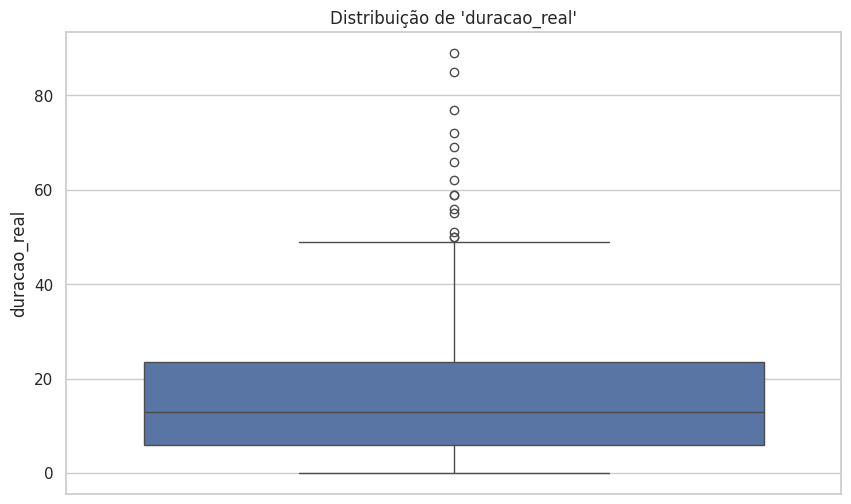

In [ ]:
# Inspecionar estatísticas básicas
print(df[['duracao_real', 'pontuacao_complexidade', 'duracao_estimada_dias']].describe())

# Checar outliers no target
plt.figure(figsize=(10, 6))
sns.boxplot(df['duracao_real'])
plt.title("Distribuição de 'duracao_real'")
plt.show()

## Criando novas features para ajustar modelo

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


# 2. Pré-processamento DIRETO (sem pipelines complexos)
# Garantir que não há NAs no target
df = df.dropna(subset=['duracao_real'])

# Features numéricas básicas (remova categóricas por enquanto)
X = df[[
    'pontuacao_complexidade',
    'pontuacao',
    'duracao_estimada_dias'
]].copy()

# Target
y = df['duracao_real']

# 3. Dividir dados (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Modelo SIMPLES (para diagnóstico)
model = RandomForestRegressor(
    n_estimators=50,  # Reduzir árvores para evitar overfitting
    max_depth=3,      # Limitar profundidade
    random_state=42
)
model.fit(X_train, y_train)

# 5. Avaliação
y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} dias")
print(f"R²: {r2_score(y_test, y_pred):.2f}")

# 6. Inspecionar previsões vs. reais
results = pd.DataFrame({'Real': y_test, 'Predito': y_pred})
print("\nAmostra de previsões:")
print(results.head(10))

MAE: 12.20 dias
R²: -0.01

Amostra de previsões:
     Real    Predito
25     34  39.820869
307     7  11.138100
73      6  16.673409
219    23  13.499125
57     77  15.380535
164    17  23.233240
279    21  25.277558
203     1  12.707871
266    29  20.191638
194     7  14.172163



Estatísticas do target (duracao_real):
count    331.000000
mean      17.166163
std       15.685533
min        0.000000
25%        6.000000
50%       13.000000
75%       23.500000
max       89.000000
Name: duracao_real, dtype: float64


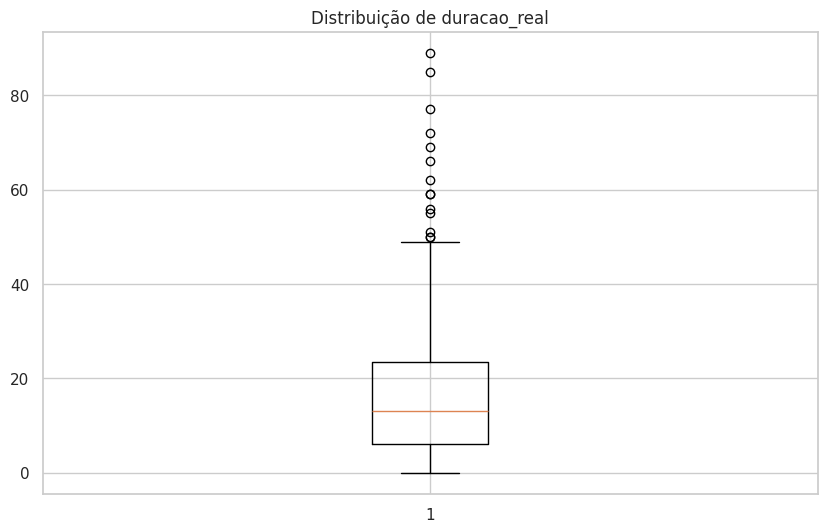

In [ ]:
print("\nEstatísticas do target (duracao_real):")
print(y.describe())

# Procurar outliers extremos
plt.figure(figsize=(10, 6))
plt.boxplot(y.dropna())
plt.title("Distribuição de duracao_real")
plt.show()

In [ ]:
y = np.clip(y, 0, 30)  # Limitar a 30 dias

In [ ]:
# 1: Complexidade ajustada por senioridade
X['complexidade_ajustada'] = X['pontuacao_complexidade'] * df['senioridade'].map({'Junior': 1.5, 'Pleno': 1.0, 'Senior': 0.7})


Modelo Baseline Simples

Comparado com uma média por categoria como baseline:

In [ ]:
# Calculo médias de duração por senioridade
media_por_senioridade = df.groupby('senioridade')['duracao_real'].mean()

# Previsão usando apenas a média
y_pred_baseline = df['senioridade'].map(media_por_senioridade)
print(f"MAE Baseline (média por senioridade): {mean_absolute_error(y, y_pred_baseline):.2f} dias")

MAE Baseline (média por senioridade): 8.94 dias


XGBoost com Parâmetros Conservadores

In [ ]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective='reg:absoluteerror'  #  MAE como métrica
)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)
print(f"XGBoost MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f} dias")

XGBoost MAE: 11.40 dias


## Melhoria do modelo

1. Análise dos outliners

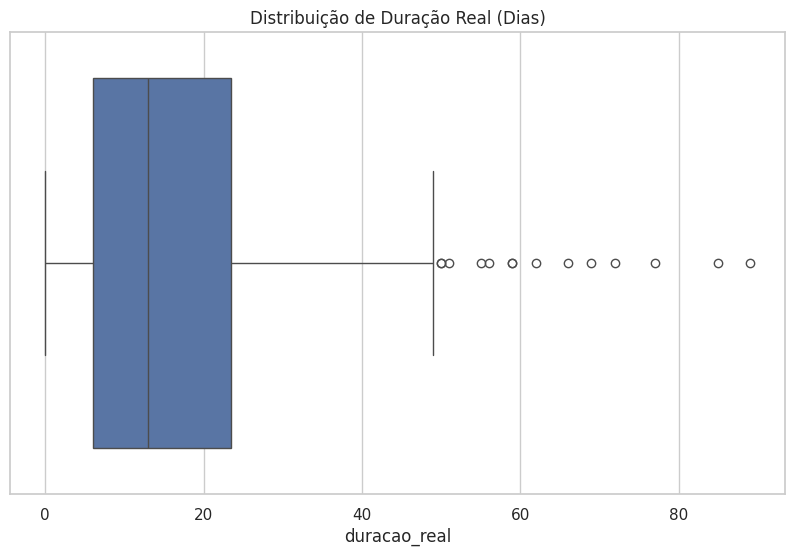

Estatísticas descritivas:
 count    331.000000
mean      17.166163
std       15.685533
min        0.000000
25%        6.000000
50%       13.000000
75%       23.500000
max       89.000000
Name: duracao_real, dtype: float64

Top 5 valores mais altos:
 41     89
54     85
57     77
129    72
162    69
Name: duracao_real, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['duracao_real'])
plt.title('Distribuição de Duração Real (Dias)')
plt.show()

print("Estatísticas descritivas:\n", df['duracao_real'].describe())
print("\nTop 5 valores mais altos:\n", df['duracao_real'].nlargest(5))

Resultado: Dados com valores muito extremos

2. Limpeza dos Dados

Remoção por percentil

In [ ]:
# Definir limite superior (ex: percentil 95%)
limite_superior = df['duracao_real'].quantile(0.90)

# Filtrar dataset
df_clean = df[df['duracao_real'] <= limite_superior].copy()
print(f"Removidos {len(df) - len(df_clean)} outliers ({(len(df)-len(df_clean))/len(df):.1%})")

Removidos 28 outliers (8.5%)


3. Verificação Pós-Limpeza

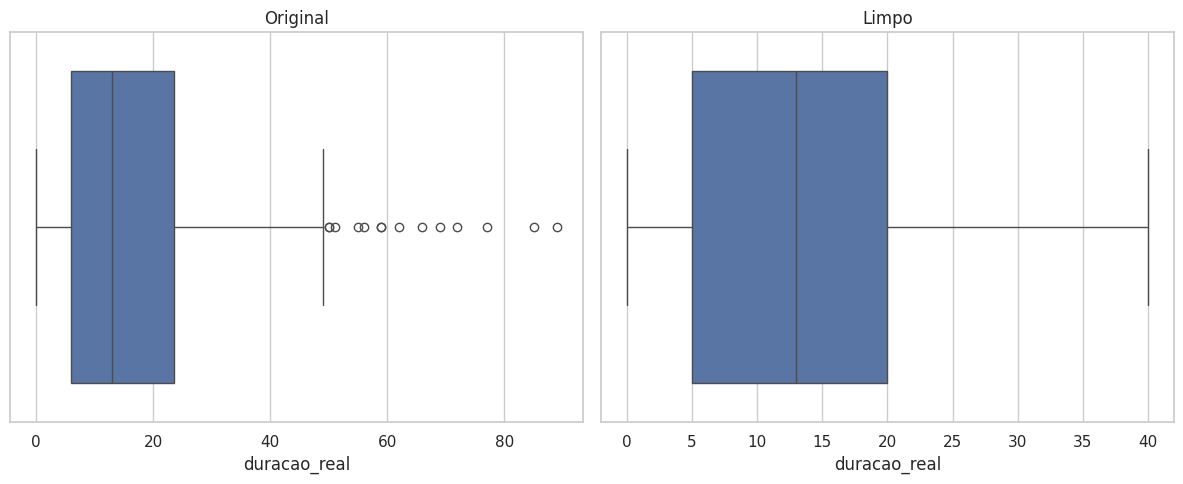

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['duracao_real'])
plt.title('Original')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_clean['duracao_real'])
plt.title('Limpo')

plt.tight_layout()
plt.show()

4. Nova Modelagem com Dados Limpos

Atualizar feature e target

In [ ]:
X_clean = df_clean[[
    'senioridade',
    'pontuacao_complexidade',
    'pontuacao',
    'duracao_estimada_dias',
    'teve_impedimento',
    'motivo_impedimento'
]]
y_clean = df_clean['duracao_real']

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

model_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=150,
        max_depth=7,
        min_samples_leaf=3,
        random_state=42
    ))
])

# Treinar e avaliar
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} dias")
print(f"R²: {r2_score(y_test, y_pred):.2f}")

MAE: 7.52 dias
R²: 0.08


5. Análise dos Resultados

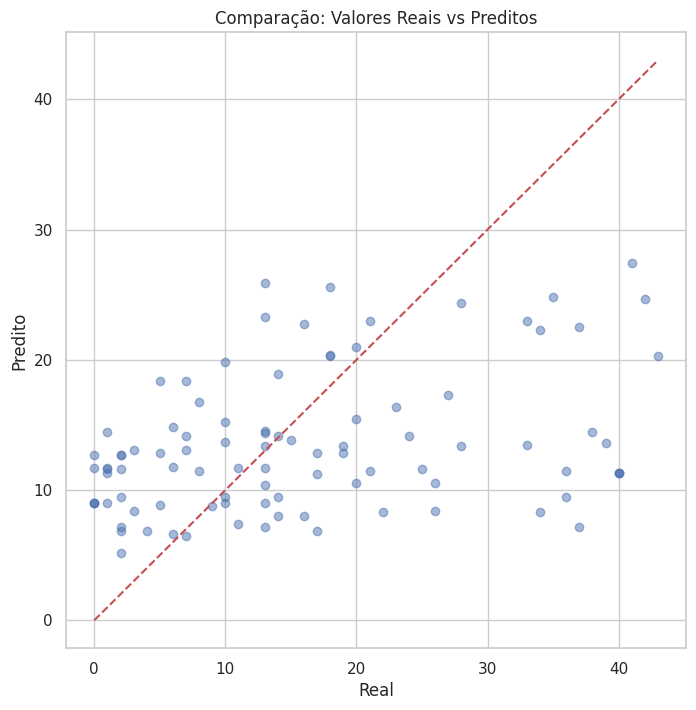

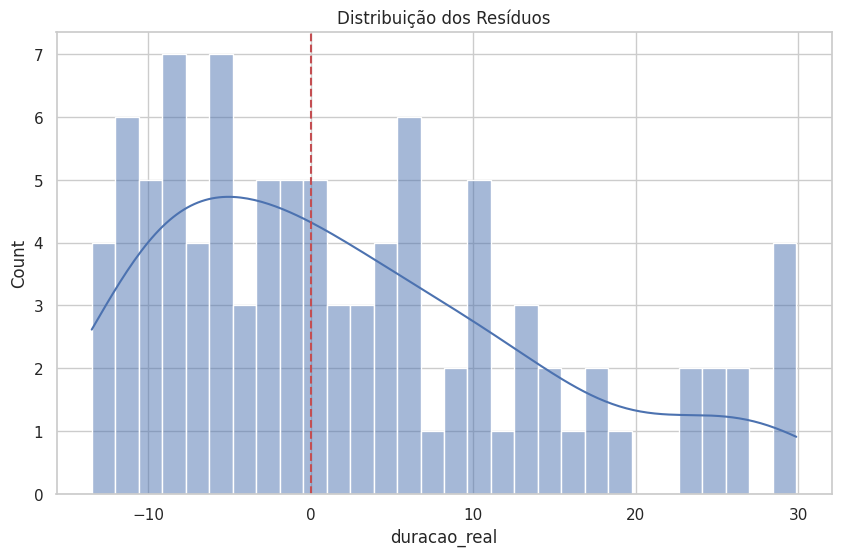

In [ ]:
# Gráfico de dispersão real vs predito
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real')
plt.ylabel('Predito')
plt.title('Comparação: Valores Reais vs Preditos')
plt.show()

# Distribuição dos erros
residuos = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuos, bins=30, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribuição dos Resíduos')
plt.show()

6. Verificações

* Verificação do corte dos outliners:

In [ ]:
print("Duração máxima após limpeza:", df_clean['duracao_real'].max())

Duração máxima após limpeza: 40


* Linhas removidas:

In [ ]:
print(f"Dataset original: {len(df)} linhas | Dataset limpo: {len(df_clean)} linhas")

Dataset original: 331 linhas | Dataset limpo: 303 linhas


1. MAE: 9,32 dias
Isso significa que, em média, o modelo erra a previsão do prazo de entrega em 9,32 dias (acima ou abaixo). Esse é um erro considerável, principalmente se a maioria das tarefas tem durações estimadas mais curtas (por exemplo, entre 2 e 10 dias).

2. R²: 0,09
O valor de R² indica que apenas 9% da variação no prazo real de entrega é explicada pelo modelo. Ou seja, 91% do que influencia o tempo real de entrega ainda está fora do que o modelo consegue capturar — isso pode indicar:

* Variáveis importantes não estão nos dados (como reuniões, qualidade das histórias, ou mudanças de escopo);

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

results_df = pd.DataFrame({
    'pontuacao_complexidade': X_test['pontuacao_complexidade'],
    'real': y_test,
    'predito': y_pred
})

metrics = results_df.groupby('pontuacao_complexidade').agg(
    qtd_tarefas=('real', 'count'),
    duracao_real_media=('real', 'mean'),
    duracao_predita_media=('predito', 'mean')
)
metrics['mae'] = results_df.groupby('pontuacao_complexidade').apply(
    lambda x: mean_absolute_error(x['real'], x['predito'])
)
metrics['diferenca_media'] = metrics['duracao_real_media'] - metrics['duracao_predita_media']
metrics['erro_relativo_percent'] = (metrics['mae'] / metrics['duracao_real_media']) * 100

metrics = metrics.sort_index().reset_index()
metrics.columns = [
    'Pontuação Complexidade',
    'Qtd. Tarefas',
    'Duração Real Média (dias)',
    'Duração Predita Média (dias)',
    'MAE (dias)',
    'Diferença Média',
    'Erro Relativo (%)'
]

total_row = {
    'Pontuação Complexidade': 'TOTAL',
    'Qtd. Tarefas': len(results_df),
    'Duração Real Média (dias)': results_df['real'].mean(),
    'Duração Predita Média (dias)': results_df['predito'].mean(),
    'MAE (dias)': mean_absolute_error(results_df['real'], results_df['predito']),
    'Diferença Média': results_df['real'].mean() - results_df['predito'].mean(),
    'Erro Relativo (%)': (mean_absolute_error(results_df['real'], results_df['predito']) / results_df['real'].mean()) * 100
}

metrics = pd.concat([metrics, pd.DataFrame([total_row])], ignore_index=True)

(metrics.style
    .format({
        'Duração Real Média (dias)': '{:.1f}',
        'Duração Predita Média (dias)': '{:.1f}',
        'MAE (dias)': '{:.1f}',
        'Diferença Média': '{:.1f}',
        'Erro Relativo (%)': '{:.1f}%'
    })
    .background_gradient(cmap='Blues', subset=['MAE (dias)'])
    .background_gradient(cmap='RdBu', vmin=-50, vmax=50, subset=['Erro Relativo (%)'])
    .set_caption('Erro Médio por Pontuação de Complexidade')
    .set_properties(**{'text-align': 'center'}))

<ipython-input-41-819a8cf46b02>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics['mae'] = results_df.groupby('pontuacao_complexidade').apply(


,Pontuação Complexidade,Qtd. Tarefas,Duração Real Média (dias),Duração Predita Média (dias),MAE (dias),Diferença Média,Erro Relativo (%)
0,0,38,12.3,12.1,7.4,0.1,60.4%
1,7,2,4.5,9.4,4.9,-4.9,109.7%
2,9,1,10.0,14.7,4.7,-4.7,47.4%
3,10,3,21.3,10.6,10.8,10.8,50.5%
4,12,1,28.0,13.9,14.1,14.1,50.4%
5,14,1,19.0,12.8,6.2,6.2,32.6%
6,15,4,16.2,10.6,9.6,5.7,59.0%
7,16,2,12.5,8.7,3.8,3.8,30.4%
8,17,4,12.2,11.1,6.7,1.1,54.4%
9,18,6,11.5,12.6,4.6,-1.1,40.2%
